In [1]:
import sys
import os
sys.path.append('../')
import numpy as np
import scipy.signal as sps
from source.reader import read_raw
from source.interference_reject import InterferenceReject
import matplotlib
matplotlib.rcParams['font.family'] = "Times New Roman"
matplotlib.rcParams['font.size'] = 18
import matplotlib.pyplot as plt

## Noise correlation (interaction matrix)

Interaction coupling K:
Primary, Min: 0.015324513427913189
Primary, Max: 0.3079428429152091
Reference, Min: 0.0014646101044490933
Reference, Max: 0.07521483276615842
Cross, Min: 0.0001556917413836345
Cross, Max: 0.011768911666999213


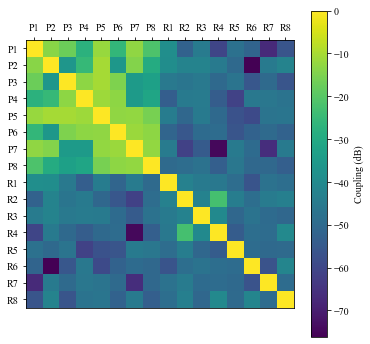

In [2]:
# Data import
file_name = "../../data_interference/shielded_room/baseline.h5"
data, index, metadata = read_raw(file_name)
num_channels_all = metadata['console']['adc']['number_channels']
num_channels_signal = metadata['rf']['receive']['num_signal_channels']
matrix_size = metadata['sequence']['encoding']['matrix_size']
acq_bandwidth = metadata['sequence']['readout']['readouts'][0]['bandwidth']

# Derive cross corelation
data_prescan = data['noise']
data_col = np.reshape(data_prescan, (data_prescan.shape[0],-1))
norm = np.std(data_col, axis=1)
data_col /= norm[:, None]
mat_cor = np.dot(np.conj(data_col), data_col.T)
mat_cor = np.dot(np.abs(np.diag(1/np.diag(mat_cor))), mat_cor)

# Print out interaction terms
mat_cross = mat_cor - np.eye(num_channels_all)
print("Interaction coupling K:")
print("Primary, Min: {}".format(np.min(np.abs(mat_cor[:num_channels_signal, :num_channels_signal]))))
print("Primary, Max: {}".format(np.max(np.abs(mat_cross[:num_channels_signal, :num_channels_signal]))))
print("Reference, Min: {}".format(np.min(np.abs(mat_cor[num_channels_signal:, num_channels_signal:]))))
print("Reference, Max: {}".format(np.max(np.abs(mat_cross[num_channels_signal:, num_channels_signal:]))))
print("Cross, Min: {}".format(np.min(np.abs(mat_cor[:num_channels_signal, num_channels_signal:]))))
print("Cross, Max: {}".format(np.max(np.abs(mat_cross[:num_channels_signal, num_channels_signal:]))))

# Figure
x_labels = ['P1','P2','P3','P4','P5','P6','P7','P8','R1','R2','R3','R4','R5','R6','R7','R8']
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,6))
im = ax.imshow(20*np.log10(np.abs(mat_cor)))#, vmin=-40, vmax=0)
ax.xaxis.tick_top()
ax.set_xticks(np.arange(16))
ax.set_xticklabels(x_labels)
ax.set_yticks(np.arange(16))
ax.set_yticklabels(x_labels)
cbar = fig.colorbar(im)
cbar.set_label('Coupling (dB)')

# Save figure
dir_data, file_data = os.path.split(file_name)
dir_fig = os.path.join(dir_data, "figures")
if not os.path.isdir(dir_fig):
    os.mkdir(dir_fig)
file_fig = os.path.splitext(file_data)[0] + ".png"
fig.savefig(os.path.join(dir_fig, file_fig))


## Shield attenuation, X-axis

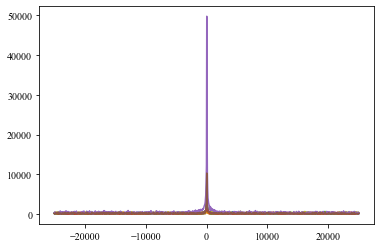

SNR primary coils: min = 8.9, max = 60.8
SNR reference coils: min = 22.9, max = 143.2
Ratio reference to primary: 2.4 (7.4 dB)


In [3]:
# Import data
file_name = "../../data_interference/shielded_room/sine_x_closed.h5"
data, index, metadata = read_raw(file_name)
num_channels_all = metadata['console']['adc']['number_channels']
num_channels_signal = metadata['rf']['receive']['num_signal_channels']
matrix_size = metadata['sequence']['encoding']['matrix_size']
acq_bandwidth = metadata['sequence']['readout']['readouts'][0]['bandwidth']

spec_scan = np.squeeze(np.fft.fftshift(np.fft.fft(data['scan'], axis=1), axes=1))
freq = np.linspace(-0.5, 0.5, spec_scan.shape[1]) * acq_bandwidth
plt.figure()
plt.plot(freq, np.squeeze(np.abs(spec_scan)).T)
plt.show()

max_sig = np.max(np.abs(spec_scan), axis=1)
sel_baseline = np.abs(freq) > 1.5e4
noise_std = np.std(spec_scan[:,sel_baseline], axis=1)
snr = max_sig / noise_std
print("SNR primary coils: min = {0:.1f}, max = {1:.1f}".format(np.min(snr[:8]), np.max(snr[:8])))
print("SNR reference coils: min = {0:.1f}, max = {1:.1f}".format(np.min(snr[8:]), np.max(snr[8:])))
r_div_p = np.max(snr[8:]) / np.max(snr[:8])
print("Ratio reference to primary: {0:.1f} ({1:.1f} dB)".format(r_div_p, 20*np.log10(r_div_p)))

## Shield attenuation, Y-axis

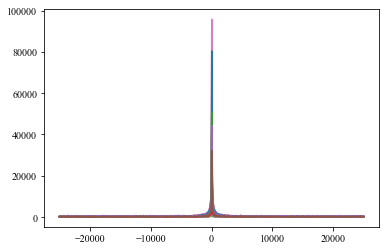

SNR primary coils: min = 6.6, max = 420.9
SNR reference coils: min = 27.9, max = 597.1
Ratio reference to primary: 1.4 (3.0 dB)


In [4]:
# Import data
file_name = "../../data_interference/shielded_room/sine_y_closed.h5"
data, index, metadata = read_raw(file_name)
num_channels_all = metadata['console']['adc']['number_channels']
num_channels_signal = metadata['rf']['receive']['num_signal_channels']
matrix_size = metadata['sequence']['encoding']['matrix_size']
acq_bandwidth = metadata['sequence']['readout']['readouts'][0]['bandwidth']

spec_scan = np.squeeze(np.fft.fftshift(np.fft.fft(data['scan'], axis=1), axes=1))
freq = np.linspace(-0.5, 0.5, spec_scan.shape[1]) * acq_bandwidth
plt.figure()
plt.plot(freq, np.squeeze(np.abs(spec_scan)).T)
plt.show()

max_sig = np.max(np.abs(spec_scan), axis=1)
sel_baseline = np.abs(freq) > 1.5e4
noise_std = np.std(spec_scan[:,sel_baseline], axis=1)
snr = max_sig / noise_std
print("SNR primary coils: min = {0:.1f}, max = {1:.1f}".format(np.min(snr[:8]), np.max(snr[:8])))
print("SNR reference coils: min = {0:.1f}, max = {1:.1f}".format(np.min(snr[8:]), np.max(snr[8:])))
r_div_p = np.max(snr[8:]) / np.max(snr[:8])
print("Ratio reference to primary: {0:.1f} ({1:.1f} dB)".format(r_div_p, 20*np.log10(r_div_p)))